# Promote financial products to bank customers 

### The industry case

In 2018, a retail bank sold several products (mortgage accounts, savings accounts, and pension accounts) to its customers.
It kept a record of all historical data, and this data is available for analysis and reuse.
Following a merger in 2019, the bank has new customers and wants to launch some marketing campaigns. 

The budget for the campaigns is limited. The bank wants to contact a customer and propose only one product.

The marketing department needs to decide:
   * Who should be contacted?
   * Which product should be proposed?  
   Proposing too many products is counter-productive, so only one product per customer contact is proposed.
   * How a customer should be contacted?  
   There are different ways, with different costs and efficiency.
   * How can they optimally use their limited budget?
   * Are such campaigns profitable?
   
### Predictive workflow

This notebook takes you through the following steps:
* From the historical data, you train a machine learning product-based classifier on a customer profile (age, income, account level, ...) to predict whether a customer would subscribe to a mortgage, savings, or pension account.
* Then, you apply this predictive model to new customer data to predict for each new customer what they might purchase.


### Table of contents:

*  [Understand the historical data](#Understand-the-historical-data)
*  [Train a model to predict customer behavior](#Train-a-model-to-predict-customer-behavior)
*  [Predict the new customer behavior](#Predict-the-new-customer-behavior)

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

# Understand the historical data

First, you can load 2018 historical data, analyze it visually, and train a classifier to predict 2019 sales.

### Load the historical customer data with their purchases (Mortgage, Savings, and Pension).

In [2]:
known_behaviors = pd.read_csv("https://raw.githubusercontent.com/vberaudi/utwt/master/known_behaviors2.csv") 
known_behaviors.head()

,customer_id,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,...,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,Mortgage,Pension,Savings
0,15,45,12,45,0,0,0,0,65,13453,...,0,4,2,1,14,19,7.602,0,0,0
1,16,43,12,43,0,0,0,0,65,13453,...,0,0,3,2,14,19,10.143,0,0,0
2,30,23,0,23,0,0,0,0,65,13453,...,0,1,0,0,14,19,0.000,0,0,0
3,42,35,8,35,1,0,0,0,65,13453,...,0,1,0,0,14,19,0.000,0,1,0
4,52,43,12,43,1,0,0,0,47,14124,...,3,1,0,0,16,35,0.000,0,1,0


In [3]:
known_behaviors.shape

(11023, 23)

### Check the 2018 customers

In [4]:
a = known_behaviors[known_behaviors.Mortgage == 1]
b = known_behaviors[known_behaviors.Pension == 1]
c = known_behaviors[known_behaviors.Savings == 1]
print("Number of clients: %d" %len(known_behaviors))
print("Number of clients predicted to buy mortgage accounts: %d" %len(a))
print("Number of clients predicted to buy pension accounts: %d" %len(b))
print("Number of clients predicted to buy savings accounts: %d" %len(c))

Number of clients: 11023
Number of clients predicted to buy mortgage accounts: 1664
Number of clients predicted to buy pension accounts: 2456
Number of clients predicted to buy savings accounts: 4222


In [5]:
known_behaviors["nb_products"] = known_behaviors.Mortgage + known_behaviors.Pension + known_behaviors.Savings

In [6]:
abc = known_behaviors[known_behaviors.nb_products > 1]
print("You have %d clients who bought several products" %len(abc))
abc = known_behaviors[known_behaviors.nb_products == 3]
print("You have %d clients who bought all the products" %len(abc))

You have 1650 clients who bought several products
You have 123 clients who bought all the products


In [7]:
products = ["Savings", "Mortgage", "Pension"]

### Provide some visual analysis of the historical data

This notebook relies on matplotlib as it is commonly used for simple visualization.

In [8]:
def plot_cloud_points(df):
    figure = plt.figure(figsize=(20, 5))
    my_cm  = ListedColormap(['#bb0000', '#00FF00'])
    axes = {p : ('age', 'income') if p != "Mortgage"else ('members_in_household', 'loan_accounts') for p in products}
    for product in products:
        ax = plt.subplot(1, len(products), products.index(product)+1)
        ax.set_title(product)
        axe = axes[product]
        plt.xlabel(axe[0])
        plt.ylabel(axe[1])
        ax.scatter(df[axe[0]], df[axe[1]], c=df[product], cmap=my_cm, alpha=0.5)

In the following visualization, you can see the behavior of the 2018 customers for the three products.
The green color indicates that a customer bought a product; red indicates a customer did not buy a product.
The depth of the color indicates the number of purchases or non-purchases.

In [ ]:
# To understand data and plot it copy the code and paste



### Understanding the 2018 customers
You can see that:
   * The greater a customer's income, the more likely it is that he or she buys a savings account.
   * The older a customer is, the more likely it is that he or she buys a pension account.
   * There is a correlation between the number of people in a customer's household, the number of loan accounts held by the customer, and the likelihood a customer buys a mortgage account. To see the correlation, look at the upper right and lower left corners of the mortgage chart.

# Train a model to predict customer behavior

You can now create and train a Machine learning model to predict customer behavior.

### Prepare data and select features to be used

In [9]:
known_behaviors.columns

Index(['customer_id', 'age', 'age_youngest_child', 'debt_equity', 'gender',
       'bad_payment', 'gold_card', 'pension_plan',
       'household_debt_to_equity_ratio', 'income', 'members_in_household',
       'months_current_account', 'months_customer', 'call_center_contacts',
       'loan_accounts', 'number_products', 'number_transactions',
       'non_worker_percentage', 'white_collar_percentage', 'rfm_score',
       'Mortgage', 'Pension', 'Savings', 'nb_products'],
      dtype='object')

Use the following columns as machine-learning features:

In [10]:
cols = ['age', 'income', 'members_in_household', 'loan_accounts']

In [11]:
y1 = known_behaviors['Mortgage']

In [12]:
y2 = known_behaviors['Pension']

In [13]:
y3 = known_behaviors['Savings']

In [14]:
X = known_behaviors[cols]

In [15]:
X.head()

,age,income,members_in_household,loan_accounts
0,45,13453,2,4
1,43,13453,2,0
2,23,13453,2,1
3,35,13453,2,1
4,43,14124,3,1


### Create and train one simple model for each product

You are using a standard basic support gradient boosting algorithm to predict whether a customer might buy product A, B, or C.

In [16]:
from sklearn import svm
from sklearn import ensemble
from sklearn.model_selection import train_test_split

In [17]:
clf = ensemble.GradientBoostingClassifier()

# Model for predicting if a customer is going to accept Mortgage 

In [18]:
#Mortgage
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2)

In [19]:
X_test.shape

(2205, 4)

In [20]:
model_mortgage = clf.fit(X_train, y_train)

In [21]:
y_pred = clf.predict(X_test)

In [22]:
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.905


# Model for predicting if a customer is going to accept Pension

In [23]:
#Pension
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2)
model_pension = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.781


# Model for predicting if a customer is going to accept Savings

In [ ]:
# Savings



# Model for predicting if a customer is going to accept Mortgage, Pension, Savings on entire dataset

In [24]:
X = known_behaviors[cols]
ys = [known_behaviors[p] for p in products]

In [25]:
classifiers = []
for i,p in enumerate(products):
    clf = ensemble.GradientBoostingClassifier()
    clf.fit(X, ys[i])
    classifiers.append(clf)

# Predict the new customer behavior

Load new customer data, predict behavior using a trained classifier, and perform some visual analysis.
You have all the characteristics of the new customers, as for the 2016 clients, but the new customers have not yet bought any product.

### Load new customer data

In [26]:
unknown_behaviors = pd.read_csv("https://raw.githubusercontent.com/vberaudi/utwt/master/unknown_behaviors.csv")
unknown_behaviors.head()


,customer_id,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score
0,44256,38,11,38,1,0,0,0,58,47958.0,4,41,48,2,1,2,1,9,31,7.949
1,46883,30,1,30,0,0,0,0,55,48606.0,2,23,36,2,4,3,2,11,33,11.437
2,32387,41,13,41,1,0,0,0,59,42152.0,4,39,48,1,0,1,1,11,29,7.462
3,25504,42,14,42,1,0,0,0,57,39788.0,3,21,24,2,3,0,0,15,27,0.000
4,35979,42,14,42,1,0,0,0,53,44365.0,6,41,48,3,2,3,1,5,41,7.806


In [27]:
for c in unknown_behaviors.columns:
    assert c in known_behaviors.columns

In [28]:
to_predict = unknown_behaviors[cols]

In [29]:
print("Number of new customers: %d" %len(unknown_behaviors))

Number of new customers: 2756


### Predict behaviors of the new customers

You can simply use the trained models from the previous section.

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
predicted = [classifiers[i].predict(to_predict) for i in range(len(products))]
for i,p in enumerate(products):
    to_predict[p] = predicted[i]
to_predict["id"] = unknown_behaviors["customer_id"]


### Package new data with predictions for optimization

In [32]:
offers = to_predict
offers.head()

,age,income,members_in_household,loan_accounts,Savings,Mortgage,Pension,id
0,38,47958.0,4,1,0,0,0,44256
1,30,48606.0,2,4,0,0,0,46883
2,41,42152.0,4,0,0,0,0,32387
3,42,39788.0,3,3,0,0,0,25504
4,42,44365.0,6,2,0,1,0,35979


### Perform some visual analysis of the predicted data

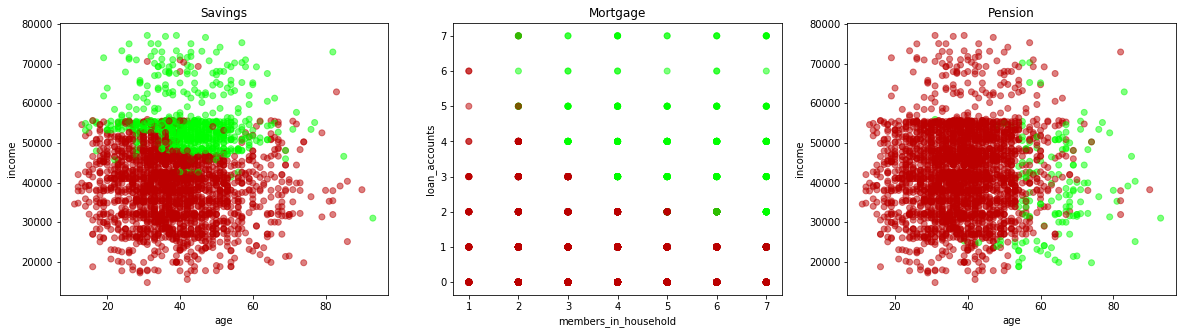

In [33]:
plot_cloud_points(offers)

The predicted data has the same semantics as the base data, with even more clear frontiers:
* for savings, there is a  clear frontier at $50K revenue.
* for pension, there is a clear frontier at 55 years old customers.

The training data contains customers who bought more than one product, take a look at the prediction

In [34]:
a = offers[offers.Mortgage == 1]
b = offers[offers.Pension == 1]
c = offers[offers.Savings == 1]
print("Number of new customers: %d" %len(offers))
print("Number of customers predicted to buy mortgages: %d" %len(a))
print("Number of customers predicted to buy pensions: %d" %len(b))
print("Number of customers predicted to buy savings: %d" %len(c))

Number of new customers: 2756
Number of customers predicted to buy mortgages: 380
Number of customers predicted to buy pensions: 142
Number of customers predicted to buy savings: 713


In [35]:
to_predict["nb_products"] = to_predict.Mortgage + to_predict.Pension + to_predict.Savings

abc = to_predict[to_predict.nb_products > 1]
print("It's predicted that %d clients would buy more than one product" %len(abc))
abc = to_predict[to_predict.nb_products == 3]
print("It's predicted that %d clients would buy all three products" %len(abc))

It's predicted that 112 clients would buy more than one product
It's predicted that 0 clients would buy all three products


#### Congratulations On finishing Lab2
